In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from src.observation import Exposure
from src.calibration import power_to_TA

# Calibration Example

관측 기기로 취득한 데이터를 과학적 의미가 있는 양으로 환산하는 과정을 cailbration이라고 합니다. 이 파일에서는 주파수의 단위로 얻은 데이터를 LSR 시선속도로 변환하는 과정을 다룹니다

이 노트북에서는 ./demo_data에 저장된 데모 데이터를 쓰기 위해 함수에 `demo=True` 를 넣습니다.
직접 관측한 데이터를 쓰고 싶으면 `demo=False` 를 넣거나, `, demo=True` 를 지우면 됩니다.

loading 40 files


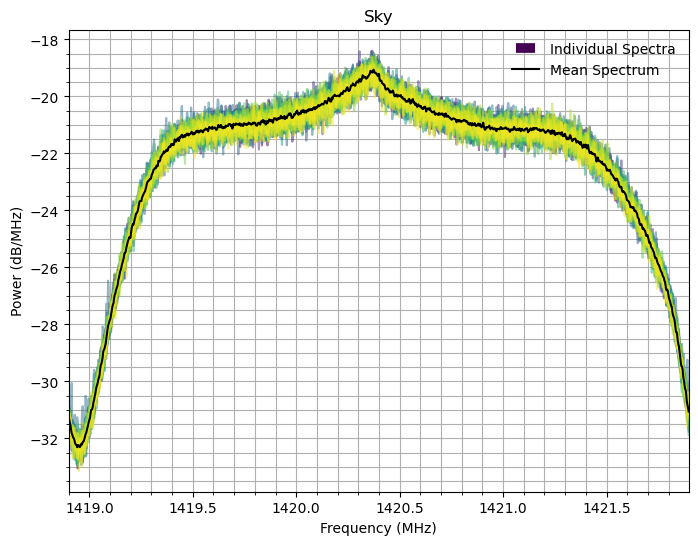

In [2]:
sky = Exposure.from_file(l=14, b=3, type="sky", demo=True)
fig, ax = sky.plot_spectrum()

loading 70 files


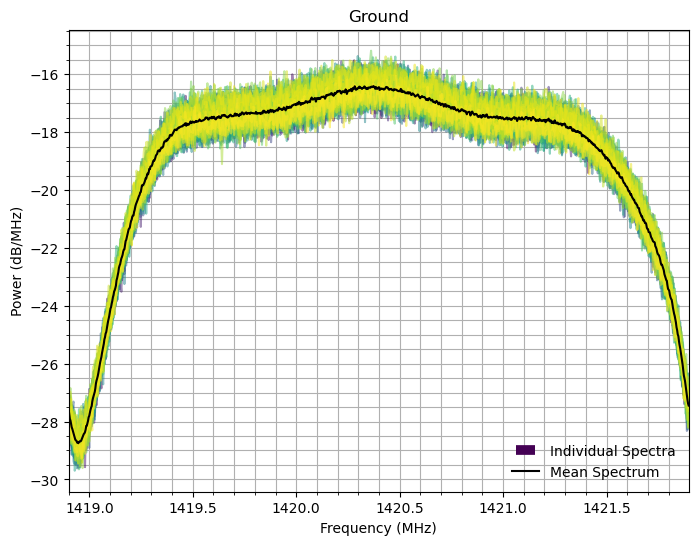

In [3]:
ground = Exposure.from_file(type="ground", demo=True)
fig, ax = ground.plot_spectrum()

## Conversion to Antenna Temperature

We start by writing
$$
P_{\mathrm{src}} = G (T_{\mathrm{src}} + T_{\mathrm{sys}}) \\
$$
$$
P_{\mathrm{amb}} = G (T_{\mathrm{amb}} + T_{\mathrm{sys}}) \\
$$
$$
P_{\mathrm{sky}} = G (0 + T_{\mathrm{sys}}) \\
$$
(spectral dependence simplified).

In our case, we couldn't take $P_{sky}$!


We use 
$$
Y = P_{\mathrm{amb}}/P_{\mathrm{sky}} \simeq P_{\mathrm{amb}}/P_{\mathrm{src}} \\
$$
$$
P_{\mathrm{sky}} \simeq \dfrac{P_{\mathrm{amb}}}{Y} \\
$$

Solving for $T_{sys}$,

$$
T_{\mathrm{sys}} = \frac{T_{amb}}{Y-1}
$$
<!-- $$
T_{\mathrm{sys}} = \frac{T_{H} - Y\times T_{L}}{Y-1}
$$ -->


, which leads to

$$
T_{\mathrm{src}} \simeq \dfrac{P_{\mathrm{src}} - P_{\mathrm{sky}}}{P_{sky}} T_{sys} = \dfrac{P_{\mathrm{src}} - P_{\mathrm{sky}}}{P_{amb} - P_{sky}} T_{amb} \\
$$

<!-- T_{sky} -->

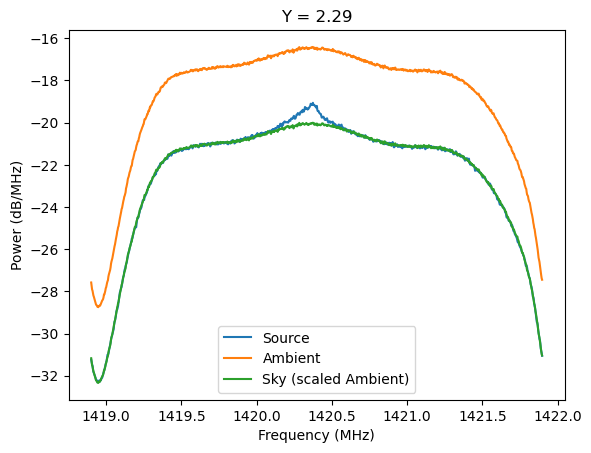

In [4]:
T_sky = 20  # Kelvin
T_amb = 300  # 273.15 K + 30 K

P_amb = ground.power
P_src = sky.power
freq = sky.freq

Y = np.median(P_amb / P_src)
P_sky = P_amb / Y

plt.plot(freq, 10 * np.log10(P_src), label="Source")
plt.plot(freq, 10 * np.log10(P_amb), label="Ambient")
plt.plot(freq, 10 * np.log10(P_sky), label="Sky (scaled Ambient)")
plt.ylabel("Power (dB/MHz)")
plt.xlabel("Frequency (MHz)")
plt.title(f"Y = {Y:.2f}")
plt.legend()
plt.show()

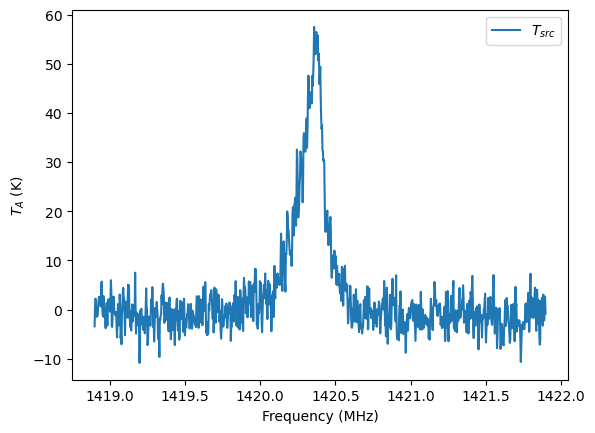

In [5]:
T_src = (P_src - P_sky) / (P_amb - P_sky) * T_amb

plt.plot(freq, T_src, label=r"$T_{src}$")
plt.ylabel(r"$T_A$ (K)")
plt.xlabel("Frequency (MHz)")
plt.legend()
plt.show()

### simpler (intermediate) code

loading 40 files
loading 70 files


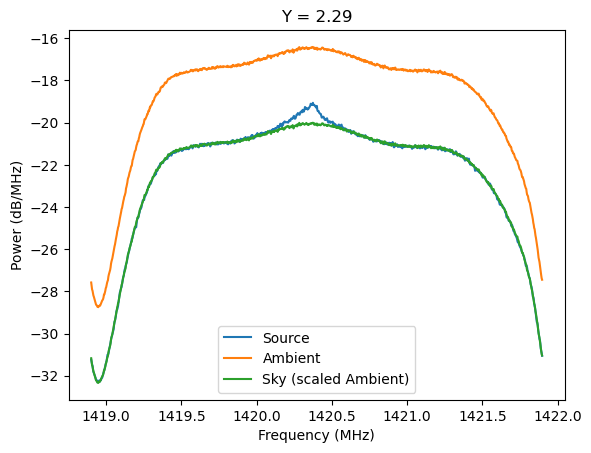

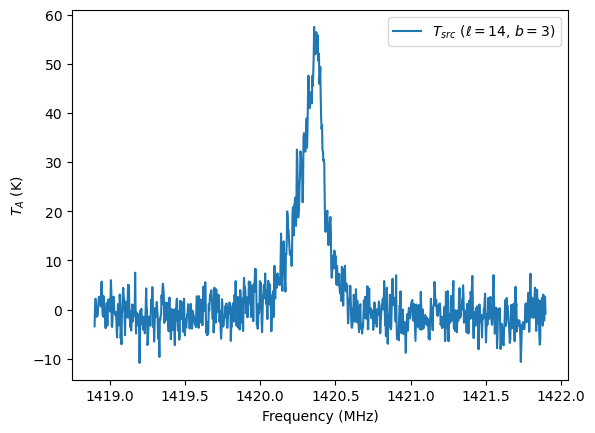

In [ ]:
sky = Exposure.from_file(l=14, b=3, type="sky", demo=True)
# sky.plot_spectrum()

ground = Exposure.from_file(type="ground", demo=True)
# ground.plot_spectrum()

freq, T_src = power_to_TA(sky, ground)

## Frequency to Velocity

We convert the frequency to line-of-sight velocity to see the kinematics of the HI gas clouds.

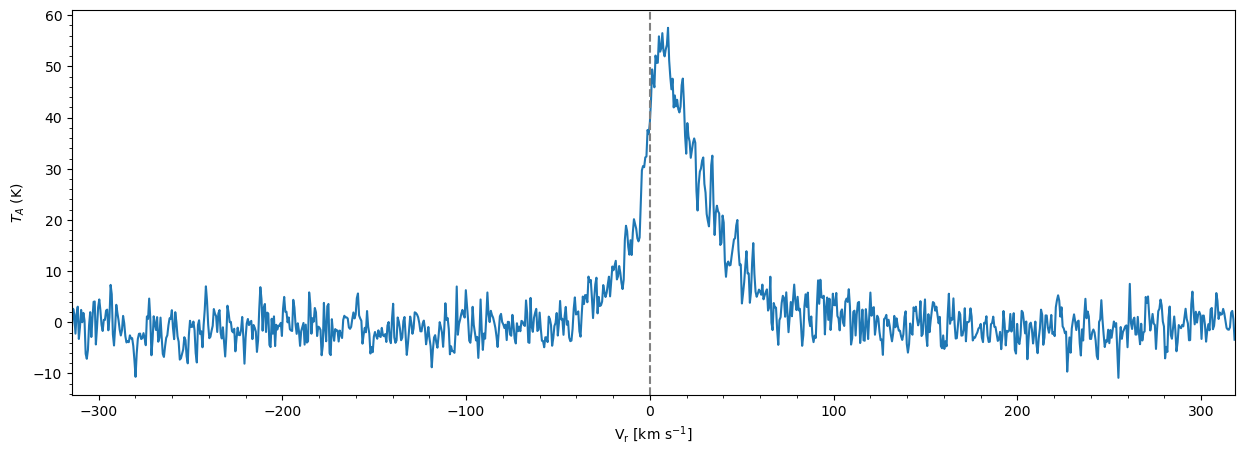

In [7]:
f0 = 1420.40575  # rest frame frequency of H1
c = 2.9979e5  # lightspeed in [km/s]

# convert frequency to radial velocity
V_r = -c * (freq - f0) / freq

plt.figure(figsize=(15, 5))
plt.plot(V_r, T_src, color="C0")
plt.axvline(0, ls="dashed", color="gray")
plt.xlim(np.min(V_r), np.max(V_r))
plt.xlabel(r"$\rm V_r\ [km\ s^{-1}]$")
plt.ylabel(r"$T_A$ (K)")
plt.minorticks_on()
plt.show()

## LSR Correction

The solar system also moves at 20.0 km/s toward l=56°, b=23° with respect to the LSR.

Decomposed, it corresponds to [U, V, W] = [10, 5, 7]

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from src.constants import observatory

obstime = sky.time
l = sky.l
b = sky.b


obj = SkyCoord(l=l * u.deg, b=b * u.deg, frame="galactic", obstime=obstime, location=observatory)

helio_corr = obj.radial_velocity_correction("heliocentric").to(u.km / u.second).value

# Peculiar velocity of sun
U, V, W = 10, 5, 7
peculiar_corr = U * np.sin(l) + V * np.cos(l)
v_corr = helio_corr + peculiar_corr
print(f"Heliocentric correction (obs → helio): {helio_corr:.2f} km/s")
print(f"Solar-motion correction (helio → LSR): {peculiar_corr:.2f} km/s")
print(f"Total LSR correction (obs → LSR): {v_corr:.2f} km/s")

Heliocentric correction (obs → helio): -19.22 km/s
Solar-motion correction (helio → LSR): 10.59 km/s
Total LSR correction (obs → LSR): -8.63 km/s


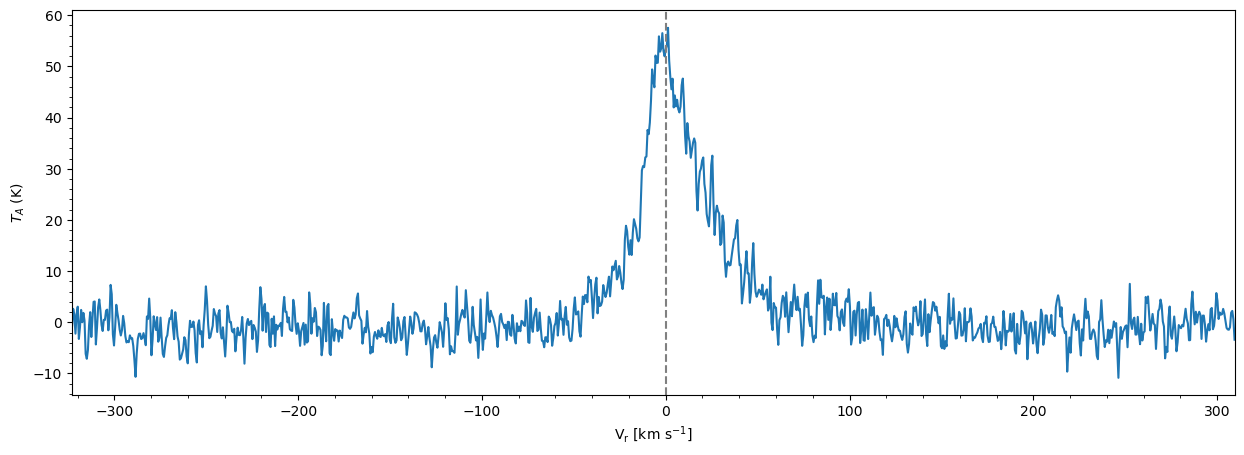

In [9]:
from src.constants import DATA_DIR

V_r = -c * (freq - f0) / freq + v_corr

plt.figure(figsize=(15, 5))
plt.plot(V_r, T_src, color="C0")
plt.axvline(0, ls="dashed", color="gray")
plt.xlim(np.min(V_r), np.max(V_r))
plt.xlabel(r"$\rm V_r\ [km\ s^{-1}]$")
plt.ylabel(r"$T_A$ (K)")
plt.minorticks_on()
plt.show()

np.save(DATA_DIR / f"Vr_{l}_{b}.npy", V_r)

# Simple Code

loading 40 files
loading 70 files


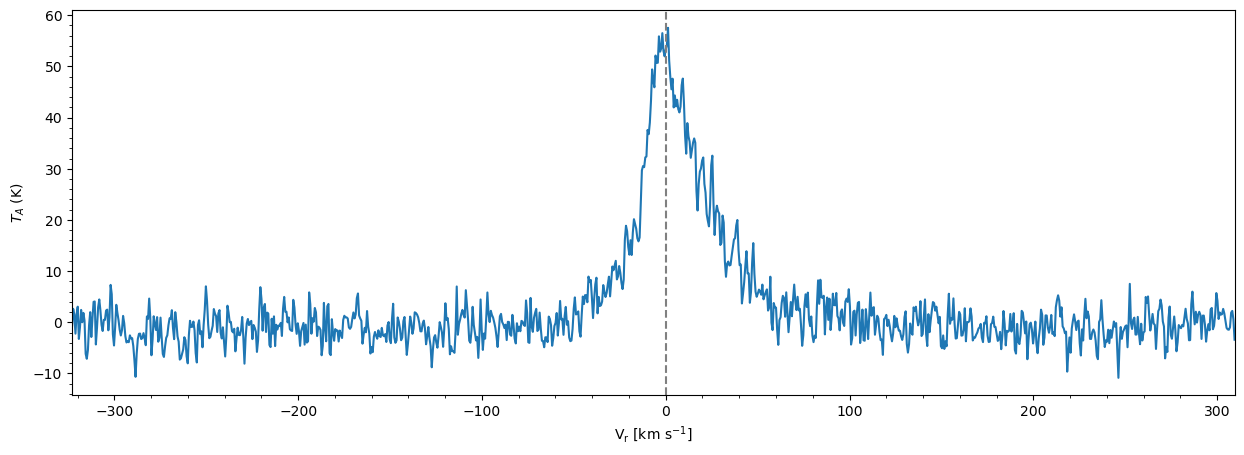

(array([ 309.51402603,  308.89437613,  308.27472878, ..., -321.81890843,
        -322.43595398, -323.052997  ]),
 array([-3.40278977,  0.55633704,  2.22543012, ...,  1.49094916,
         2.62744846, -0.78939172]))

In [10]:
from src.calibration import calibrate

calibrate(l=14, b=3, plot=True, demo=True)

If you want to see all intermediate steps, supply `intermediate_plot=True`

loading 40 files
loading 70 files


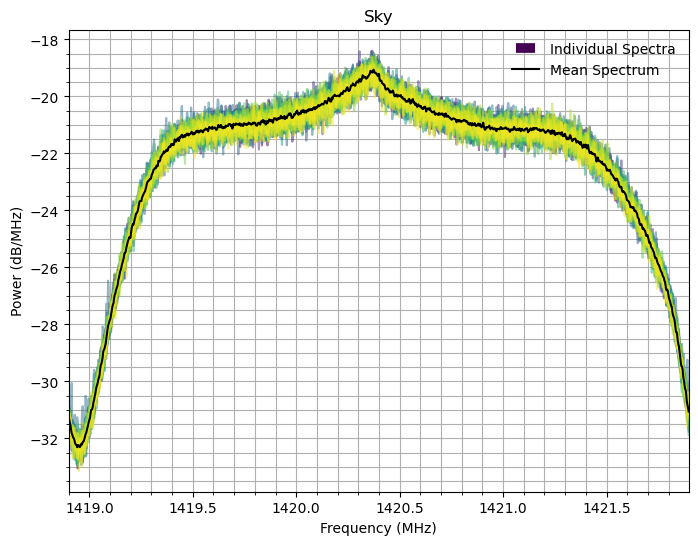

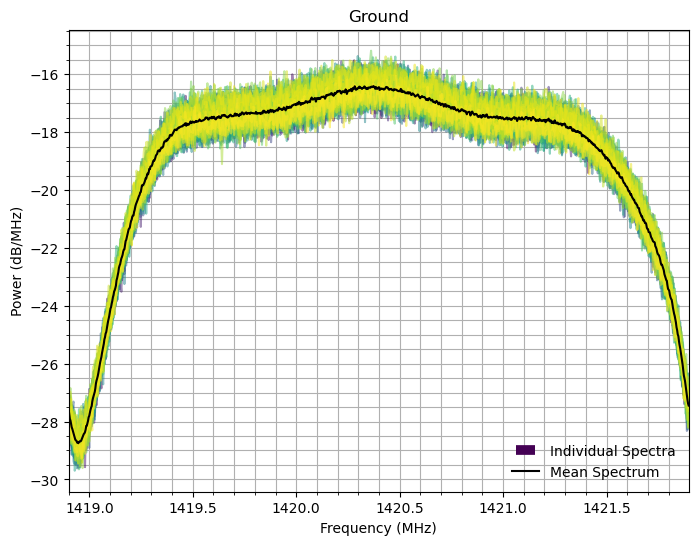

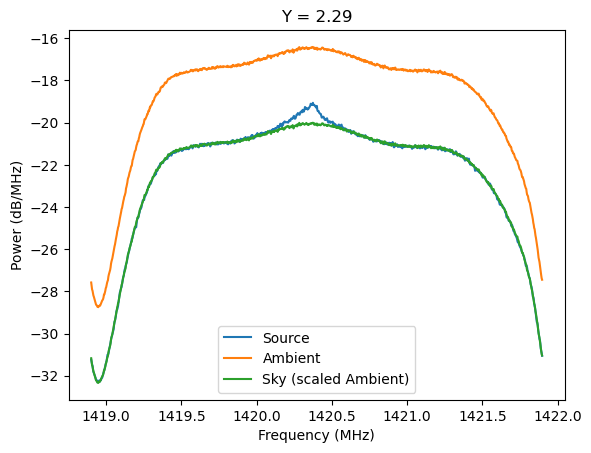

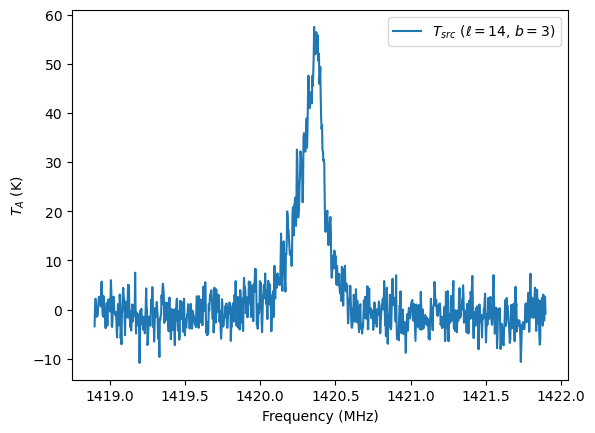

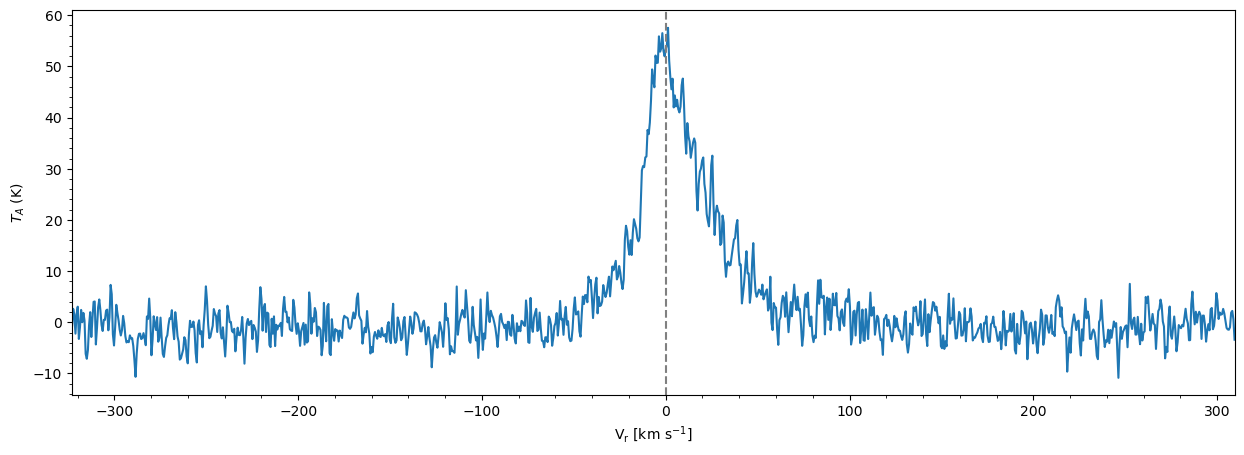

In [12]:
from src.calibration import calibrate

V_r, T_src = calibrate(l=14, b=3, intermediate_plot=True, demo=True)